In [1]:
import os
import sys
import logging
from pathlib import Path

# --- Setup Project Root and Python Path ---
current_dir = Path().resolve()
project_root = next((p for p in [current_dir, current_dir.parent] if (p / 'src').exists()), None)
if not project_root: raise FileNotFoundError("Could not find 'src' directory.")
if str(project_root) not in sys.path: sys.path.insert(0, str(project_root))
os.environ['PYTHONPATH'] = str(project_root)

# --- Import Project Modules ---
from src.utils.config_validator import load_and_merge_configs, print_config_summary
from src.data.dataset_manager import DatasetManager
from src.training.model_manager import ModelManager
from src.training.progressive_trainer import ProgressiveTrainer
from src.evaluation.evaluator import Evaluator
from ultralytics import YOLO
from IPython.display import Image as IPyImage, display
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt
from src.data.augmentation import create_rand_augment_transform

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] [%(name)s] - %(message)s')
logger = logging.getLogger("Two_Stage_Notebook")

### STAGE 1: TRAIN THE DETECTION HEAD

In [2]:
logger.info("="*80)
logger.info("▶️ CONFIGURING STAGE 1: TRAIN HEAD")
logger.info("="*80)

BASE_CONFIG_PATH = project_root / 'configs' / 'base_config.yaml'
STAGE1_CONFIG_PATH = project_root / 'configs' / 'task2_stage1.yaml'

config_s1 = load_and_merge_configs(str(BASE_CONFIG_PATH), str(STAGE1_CONFIG_PATH))
print_config_summary(config_s1)

2025-09-26 20:10:42,568 - INFO - ================================================================================
2025-09-26 20:10:42,568 - INFO - ▶️ CONFIGURING STAGE 1: TRAIN HEAD
2025-09-26 20:10:42,569 - INFO - ================================================================================
2025-09-26 20:10:42,574 - INFO - ✅ Configurations merged: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/configs/base_config.yaml + /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/configs/task2_stage1.yaml
2025-09-26 20:10:42,575 - INFO - 📋 Configuration Summary:
2025-09-26 20:10:42,575 - INFO -   Model: yolo11n.pt
2025-09-26 20:10:42,575 - INFO -   Classes: 85
2025-09-26 20:10:42,576 - INFO -   Device: 0,1
2025-09-26 20:10:42,576 - INFO -   Batch Size: 512
2025-09-26 20:10:42,576 - INFO -   Epochs: 75
2025-09-26 20:10:42,576 - INFO -   Image Size: 640
2025-09-26 20:10:42,577 - INFO -   Seed: 42
2025-09-26 20:10:42,577 - INFO -   Learning Rate: 0.001 (scaled from 0.0001 for batch size 512)
2025-09-

In [3]:
logger.info("💾 Initializing and preparing datasets (this will only run once)...")
data_manager = DatasetManager(config_s1)
data_manager.setup_datasets(task_type='task2')
logger.info("✅ DatasetManager setup is complete.")


2025-09-26 20:10:42,582 - INFO - 💾 Initializing and preparing datasets (this will only run once)...
2025-09-26 20:10:44,206 - INFO - 🌱 Random seeds set to 42 for reproducibility.
2025-09-26 20:10:44,207 - INFO - 🚀 Starting dataset setup for task: 'task2'...
2025-09-26 20:10:44,208 - INFO - ✨ Performing first-time setup for the dataset.
2025-09-26 20:10:44,211 - INFO - Downloading 'coco_143_sample.zip' from Hugging Face repo 'VivekChandra/COCO_143'...


coco_143_sample.zip:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

2025-09-26 20:10:55,702 - INFO - Extracting 'coco_143_sample.zip' to outputs/datasets/coco_source...
2025-09-26 20:16:28,919 - INFO - Extraction complete for 'VivekChandra/COCO_143'.
2025-09-26 20:16:28,930 - INFO - Downloading 'HomeObjects-3K_5class_14_per_class.zip' from Hugging Face repo 'VivekChandra/HomeObjects-3K_5class_14_per_class'...


HomeObjects-3K_5class_14_per_class.zip:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

2025-09-26 20:16:29,682 - INFO - Extracting 'HomeObjects-3K_5class_14_per_class.zip' to outputs/datasets/homeobjects_source/task2...
2025-09-26 20:16:31,262 - INFO - Extraction complete for 'VivekChandra/HomeObjects-3K_5class_14_per_class'.
2025-09-26 20:16:31,264 - INFO - Scanning for novel training images in: outputs/datasets/homeobjects_source/task2/images/train
2025-09-26 20:16:31,266 - INFO - ✅ Found 50 novel training image filenames.
2025-09-26 20:16:31,266 - INFO - 💿 Creating combined dataset on disk...
2025-09-26 20:16:31,266 - INFO -   - Processing 'train' split...
2025-09-26 20:19:24,076 - INFO -   - Processing 'val' split...
2025-09-26 20:20:18,828 - INFO -   - Processing 'test' split...
2025-09-26 20:20:43,432 - INFO - Master dataset YAML created at: outputs/combined_dataset/task2/dataset.yaml
2025-09-26 20:20:43,433 - INFO - ✅ First-time dataset setup complete.
2025-09-26 20:20:43,434 - INFO - ✅ DatasetManager setup is complete.


In [4]:
logger.info("="*80)
logger.info("▶️ EXECUTING STAGE 1: TRAIN HEAD")
logger.info("="*80)

model_manager_s1 = ModelManager(config_s1, data_manager)
trainer_s1 = ProgressiveTrainer(config_s1, data_manager, model_manager_s1)
model_s1 = trainer_s1.run_training()

2025-09-26 20:20:55,217 - INFO - ================================================================================
2025-09-26 20:20:55,218 - INFO - ▶️ EXECUTING STAGE 1: TRAIN HEAD
2025-09-26 20:20:55,219 - INFO - ================================================================================
2025-09-26 20:20:55,219 - INFO - ModelManager initialized on device 'cuda:0'.
2025-09-26 20:20:55,219 - INFO - Loading pre-trained model: yolo11n.pt...
2025-09-26 20:20:55,541 - INFO - Freezing the first 22 layers of the model backbone...
2025-09-26 20:20:55,542 - INFO - Successfully froze 22 layers.
2025-09-26 20:20:55,542 - INFO - ✅ Model 'yolo11n.pt' is configured and ready for training.
2025-09-26 20:20:55,543 - INFO - --- Model Parameters ---
2025-09-26 20:20:55,543 - INFO -   - Total:     2,624,080
2025-09-26 20:20:55,544 - INFO -   - Trainable: 843,792
2025-09-26 20:20:55,544 - INFO -   - Frozen:    1,780,288
2025-09-26 20:20:55,544 - INFO - ------------------------
2025-09-26 20:20:55,547 

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_5.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fals

2025-09-26 20:44:59,027 - INFO - --- Processing results for Phase 1 with custom evaluation ---
2025-09-26 20:44:59,033 - INFO - Loading best model from Phase 1 for detailed evaluation...
2025-09-26 20:44:59,059 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 681.8±132.0 MB/s, size: 178.8 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 1.9Kit/s 0.6s1ss
val: New cache created: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.5it/s 10.9s2.3s
                   all       1125      10371      0.558      0.377      0.486      0.347
                person        582       2451      0.729      0.662      0.743      0.511
               bicycle         35         80       0.62      0.388      0.553      0.314
                   car        114        431      0.624       0.49      0.557      0.365
            motorcycle         32        101      0.739      0.337      0.561      0.362
              airplane         19         30      0.762      0.533       0.68      0.482
                   bus         34         47      0.763      0.617      0.743      0.652
                 train         24         32      0.636      0.438      0.576       0.46
                 truck         63        103      0.471       0.32       0.35      0.247
                  boat         21         74      0.562      0.365   

2025-09-26 20:45:15,186 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 20:45:15,225 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5163        0.0000  0.4859
mAP@50-95       0.3688        0.0000  0.3471
2025-09-26 20:45:15,227 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       51.63%         0.00%  48.59%
mAP@50-95       36.88%         0.00%  34.71%
2025-09-26 20:45:15,227 - INFO - ✅ Final evaluation complete.
2025-09-26 20:45:15,227 - INFO - Phase 1 Model Perf: Base mAP=0.5163, Novel mAP=0.0000
2025-09-26 20:45:15,228 - INFO - ✅ Base mAP (0.5163) PASSED the safety net (0.4000).
2025-09-26 20:45:15,228 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 20:45:15,228 - INFO - Novel mAP improved from -1.0000 to 0.0000
2025-09-26 20:45:15,229 - INFO - 
🚀 Starting Phase 2/6
2025-09-26 20:45:15,229 - INFO - 📝 Creating phas

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_10.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 21:07:39,291 - INFO - --- Processing results for Phase 2 with custom evaluation ---
2025-09-26 21:07:39,295 - INFO - Loading best model from Phase 2 for detailed evaluation...
2025-09-26 21:07:39,320 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 629.8±97.7 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.1Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.6s2.3ss
                   all       1125      10371      0.543      0.383      0.482      0.337
                person        582       2451      0.738      0.665      0.748      0.514
               bicycle         35         80      0.579      0.412      0.518      0.333
                   car        114        431      0.587      0.478       0.54      0.348
            motorcycle         32        101      0.765      0.386      0.592      0.317
              airplane         19         30       0.68      0.567      0.708      0.463
                   bus         34         47      0.644      0.617      0.716      0.614
                 train         24         32      0.643      0.562      0.636      0.421
                 truck         63        103      0.437      0.301      0.329      0.239
                  boat         21         74      0.458      0.297   

2025-09-26 21:07:50,944 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 21:07:50,947 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5125        0.0000  0.4823
mAP@50-95       0.3576        0.0000  0.3366
2025-09-26 21:07:50,948 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       51.25%         0.00%  48.23%
mAP@50-95       35.76%         0.00%  33.66%
2025-09-26 21:07:50,948 - INFO - ✅ Final evaluation complete.
2025-09-26 21:07:50,949 - INFO - Phase 2 Model Perf: Base mAP=0.5125, Novel mAP=0.0000
2025-09-26 21:07:50,949 - INFO - ✅ Base mAP (0.5125) PASSED the safety net (0.4000).
2025-09-26 21:07:50,949 - INFO - Novel mAP (0.0000) did not improve upon the best of 0.0000.
2025-09-26 21:07:50,949 - INFO - 
🚀 Starting Phase 3/6
2025-09-26 21:07:50,949 - INFO - 📝 Creating phase-specific YAML (novel_ratio=0.25)...
2025-09-26 21:0

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_25.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 21:27:14,820 - INFO - --- Processing results for Phase 3 with custom evaluation ---
2025-09-26 21:27:14,823 - INFO - Loading best model from Phase 3 for detailed evaluation...
2025-09-26 21:27:14,851 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 660.1±88.3 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.4Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.9s2.2ss
                   all       1125      10371      0.553      0.364      0.471      0.332
                person        582       2451      0.723      0.666      0.739      0.506
               bicycle         35         80      0.525        0.4      0.491      0.287
                   car        114        431      0.585      0.457       0.54      0.338
            motorcycle         32        101      0.775      0.307      0.562      0.371
              airplane         19         30      0.727      0.533      0.695      0.475
                   bus         34         47      0.633       0.66      0.697      0.626
                 train         24         32      0.696        0.5      0.664      0.461
                 truck         63        103      0.564      0.301      0.427      0.286
                  boat         21         74      0.468      0.297   

2025-09-26 21:27:26,700 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 21:27:26,703 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5005        0.0000  0.4711
mAP@50-95       0.3525        0.0000  0.3317
2025-09-26 21:27:26,704 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       50.05%         0.00%  47.11%
mAP@50-95       35.25%         0.00%  33.17%
2025-09-26 21:27:26,704 - INFO - ✅ Final evaluation complete.
2025-09-26 21:27:26,705 - INFO - Phase 3 Model Perf: Base mAP=0.5005, Novel mAP=0.0000
2025-09-26 21:27:26,705 - INFO - ✅ Base mAP (0.5005) PASSED the safety net (0.4000).
2025-09-26 21:27:26,705 - INFO - Novel mAP (0.0000) did not improve upon the best of 0.0000.
2025-09-26 21:27:26,706 - INFO - 
🚀 Starting Phase 4/6
2025-09-26 21:27:26,707 - INFO - 📝 Creating phase-specific YAML (novel_ratio=0.50)...
2025-09-26 21:2

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_50.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 21:41:43,503 - INFO - --- Processing results for Phase 4 with custom evaluation ---
2025-09-26 21:41:43,507 - INFO - Loading best model from Phase 4 for detailed evaluation...
2025-09-26 21:41:43,535 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 615.3±116.3 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.6Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 9.1s2.4ss
                   all       1125      10371      0.588      0.352      0.479      0.341
                person        582       2451      0.748      0.642      0.732      0.503
               bicycle         35         80      0.821        0.4      0.608      0.359
                   car        114        431      0.617      0.445      0.538      0.339
            motorcycle         32        101      0.786      0.327      0.573      0.361
              airplane         19         30       0.75        0.5       0.64      0.473
                   bus         34         47      0.794      0.574      0.717      0.649
                 train         24         32      0.824      0.438       0.64      0.471
                 truck         63        103      0.444      0.272      0.351      0.268
                  boat         21         74      0.625       0.27   

2025-09-26 21:41:55,458 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 21:41:55,461 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5004        0.1400  0.4792
mAP@50-95       0.3556        0.1060  0.3409
2025-09-26 21:41:55,462 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       50.04%        14.00%  47.92%
mAP@50-95       35.56%        10.60%  34.09%
2025-09-26 21:41:55,463 - INFO - ✅ Final evaluation complete.
2025-09-26 21:41:55,463 - INFO - Phase 4 Model Perf: Base mAP=0.5004, Novel mAP=0.1400
2025-09-26 21:41:55,463 - INFO - ✅ Base mAP (0.5004) PASSED the safety net (0.4000).
2025-09-26 21:41:55,464 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 21:41:55,464 - INFO - Novel mAP improved from 0.0000 to 0.1400
2025-09-26 21:41:55,464 - INFO - 
🚀 Starting Phase 5/6
2025-09-26 21:41:55,465 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_75.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 21:51:05,976 - INFO - --- Processing results for Phase 5 with custom evaluation ---
2025-09-26 21:51:05,979 - INFO - Loading best model from Phase 5 for detailed evaluation...
2025-09-26 21:51:06,006 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 692.4±108.4 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 4.2Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.9s2.4ss
                   all       1125      10371      0.536      0.323      0.442       0.31
                person        582       2451       0.72      0.655      0.731      0.497
               bicycle         35         80      0.587      0.338      0.449      0.248
                   car        114        431      0.606      0.436      0.553       0.35
            motorcycle         32        101      0.692      0.446       0.59      0.354
              airplane         19         30       0.68      0.567      0.698       0.45
                   bus         34         47      0.694      0.532      0.683      0.583
                 train         24         32      0.739      0.531      0.644      0.419
                 truck         63        103       0.38      0.262      0.313      0.221
                  boat         21         74      0.333       0.23   

2025-09-26 21:51:17,695 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 21:51:17,698 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4597        0.1563  0.4419
mAP@50-95       0.3211        0.1285  0.3098
2025-09-26 21:51:17,699 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       45.97%        15.63%  44.19%
mAP@50-95       32.11%        12.85%  30.98%
2025-09-26 21:51:17,699 - INFO - ✅ Final evaluation complete.
2025-09-26 21:51:17,700 - INFO - Phase 5 Model Perf: Base mAP=0.4597, Novel mAP=0.1563
2025-09-26 21:51:17,700 - INFO - ✅ Base mAP (0.4597) PASSED the safety net (0.4000).
2025-09-26 21:51:17,700 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 21:51:17,700 - INFO - Novel mAP improved from 0.1400 to 0.1563
2025-09-26 21:51:17,701 - INFO - 
🚀 Starting Phase 6/6
2025-09-26 21:51:17,701 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_90.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.25, multi_scale=Fal

2025-09-26 21:57:42,063 - INFO - --- Processing results for Phase 6 with custom evaluation ---
2025-09-26 21:57:42,067 - INFO - Loading best model from Phase 6 for detailed evaluation...
2025-09-26 21:57:42,096 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 744.2±123.9 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.2Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.9s2.3ss
                   all       1125      10371       0.66      0.174       0.42      0.313
                person        582       2451      0.925      0.443      0.692       0.51
               bicycle         35         80      0.852      0.287      0.565       0.31
                   car        114        431      0.867      0.241      0.556      0.387
            motorcycle         32        101          1      0.198      0.599      0.424
              airplane         19         30      0.652        0.5       0.62      0.438
                   bus         34         47      0.895      0.362      0.648      0.558
                 train         24         32          1      0.438      0.719      0.443
                 truck         63        103      0.714      0.146      0.415      0.298
                  boat         21         74          0          0   

2025-09-26 21:57:53,769 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 21:57:53,772 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4462        0.0000  0.4200
mAP@50-95       0.3327        0.0000  0.3131
2025-09-26 21:57:53,773 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       44.62%         0.00%  42.00%
mAP@50-95       33.27%         0.00%  31.31%
2025-09-26 21:57:53,773 - INFO - ✅ Final evaluation complete.
2025-09-26 21:57:53,773 - INFO - Phase 6 Model Perf: Base mAP=0.4462, Novel mAP=0.0000
2025-09-26 21:57:53,774 - INFO - ✅ Base mAP (0.4462) PASSED the safety net (0.4000).
2025-09-26 21:57:53,774 - INFO - Novel mAP (0.0000) did not improve upon the best of 0.1563.
2025-09-26 21:57:53,774 - INFO - 🏆 Saving overall best model from /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage1_train_head_p

2025-09-26 21:57:55,276 - INFO - ================================================================================
2025-09-26 21:57:55,277 - INFO - ▶️ ANALYZING STAGE 1 RESULTS
2025-09-26 21:57:55,277 - INFO - ================================================================================
2025-09-26 21:57:55,278 - INFO - Displaying training summary plot for Stage 1 from: outputs/training_summary_plots_task_10shot_stage1_train_head.png


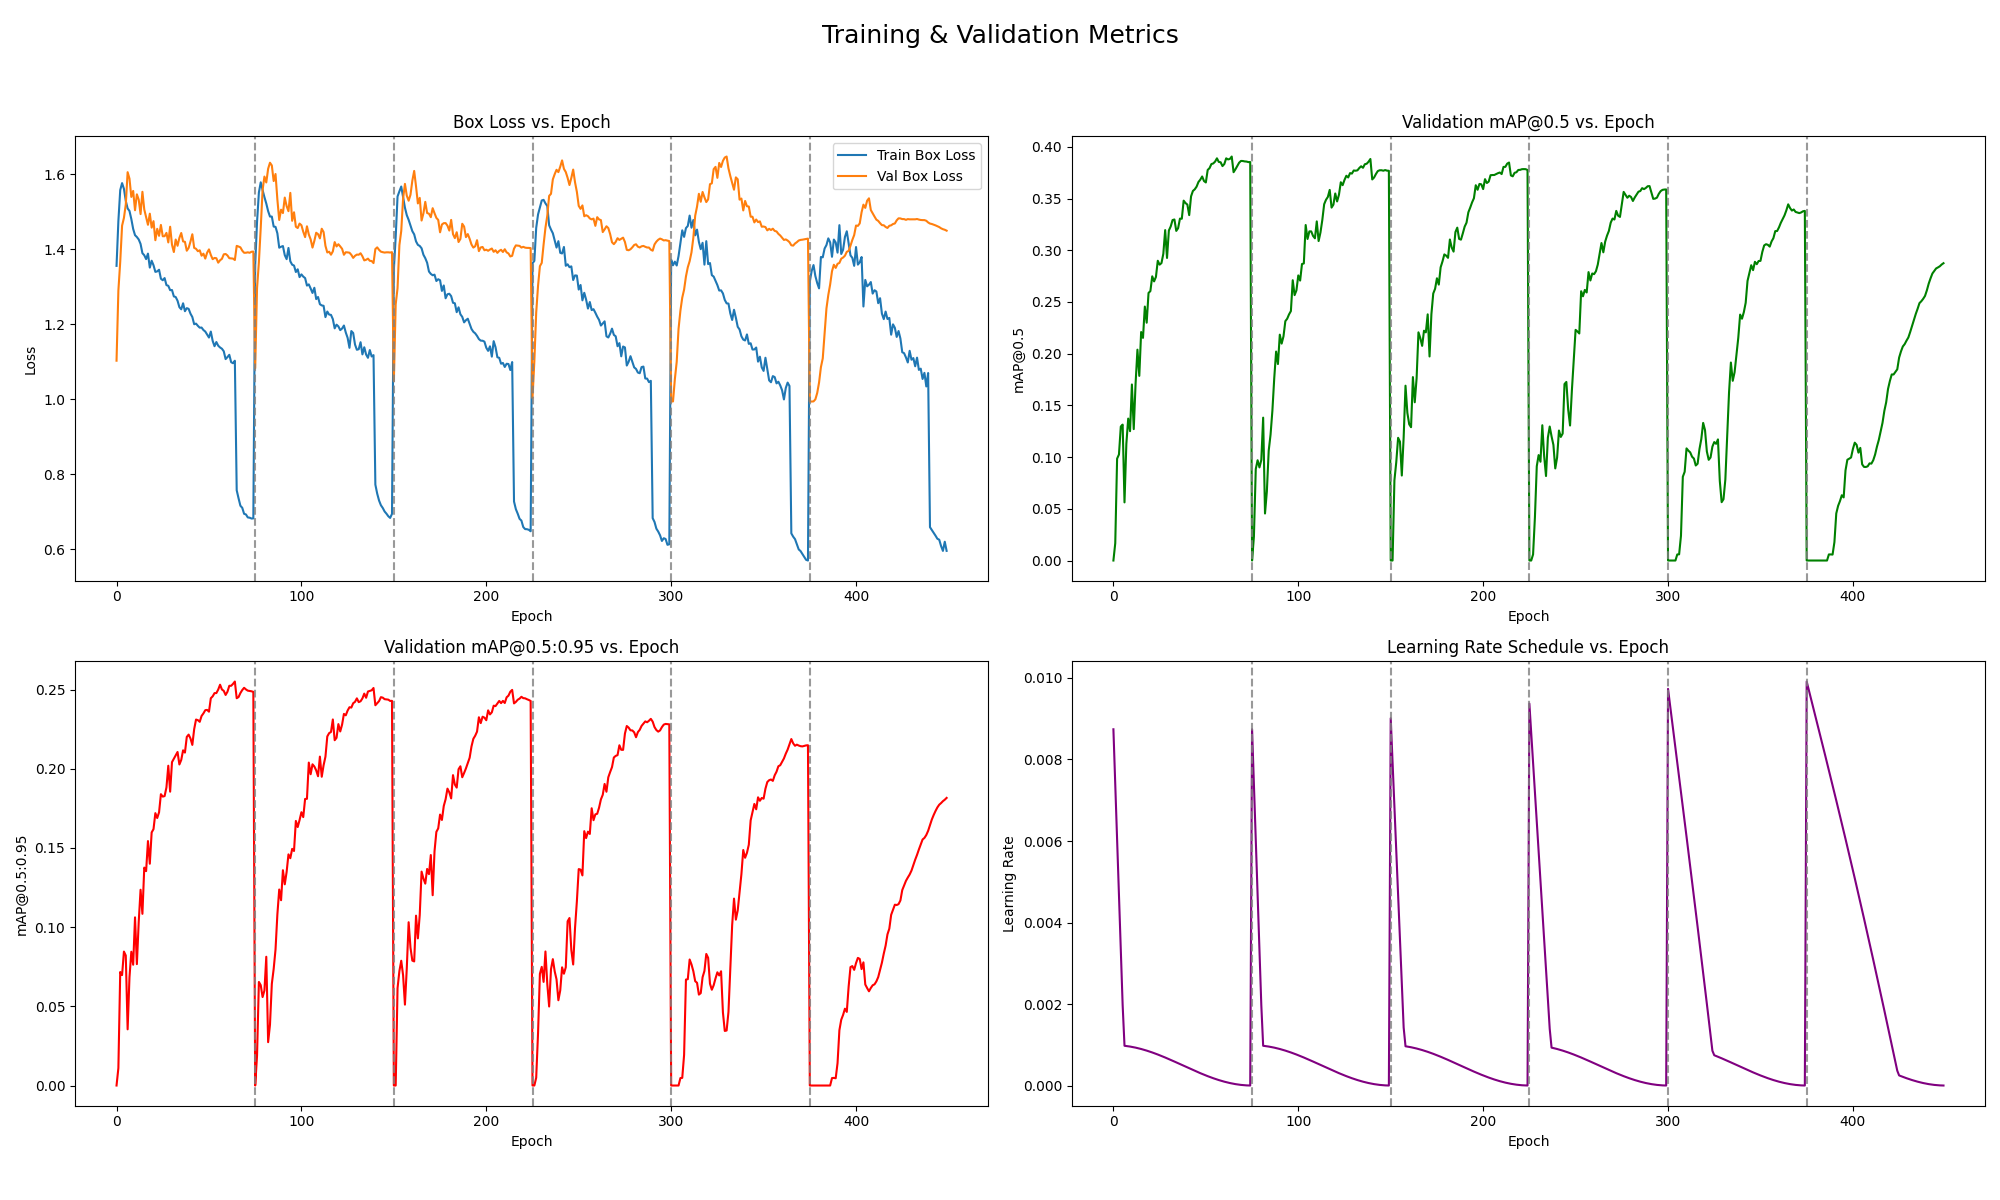

2025-09-26 21:57:55,282 - INFO - Loading best model from Stage 1: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage1_train_head_phase_5/weights/best.pt
2025-09-26 21:57:55,350 - INFO - Evaluator initialized for 80 base and 5 novel classes.
2025-09-26 21:57:55,350 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 553.3±206.4 MB/s, size: 143.9 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 4.1Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.3s1.9ss
                   all       1125      10371      0.536      0.323      0.442       0.31
                person        582       2451       0.72      0.655      0.731      0.497
               bicycle         35         80      0.587      0.338      0.449      0.248
                   car        114        431      0.606      0.436      0.553       0.35
            motorcycle         32        101      0.692      0.446       0.59      0.354
              airplane         19         30       0.68      0.567      0.698       0.45
                   bus         34         47      0.694      0.532      0.683      0.583
                 train         24         32      0.739      0.531      0.644      0.419
                 truck         63        103       0.38      0.262      0.313      0.221
                  boat         21         74      0.333       0.23   

2025-09-26 21:58:07,209 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 21:58:07,212 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4597        0.1563  0.4419
mAP@50-95       0.3211        0.1285  0.3098
2025-09-26 21:58:07,213 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       45.97%        15.63%  44.19%
mAP@50-95       32.11%        12.85%  30.98%
2025-09-26 21:58:07,213 - INFO - ✅ Final evaluation complete.


In [5]:
logger.info("="*80)
logger.info("▶️ ANALYZING STAGE 1 RESULTS")
logger.info("="*80)

# --- Display Stage 1 Training Summary Plot ---
output_dir_s1 = Path(config_s1['output_dir'])
plot_path_s1 = output_dir_s1 / f"training_summary_plots_{config_s1['task_name']}.png"
if plot_path_s1.exists():
    logger.info(f"Displaying training summary plot for Stage 1 from: {plot_path_s1}")
    display(IPyImage(filename=str(plot_path_s1)))
else:
    logger.warning(f"Could not find Stage 1 summary plot at {plot_path_s1}")

# --- Evaluate the Stage 1 Model ---
stage1_best_model_path = trainer_s1.overall_best_model_path
if stage1_best_model_path and stage1_best_model_path.exists():
    logger.info(f"Loading best model from Stage 1: {stage1_best_model_path}")
    final_model_s1 = YOLO(str(stage1_best_model_path))
    
    evaluator_s1 = Evaluator(config_s1, data_manager)
    evaluator_s1.evaluate_model(final_model_s1)
else:
    logger.error("Could not find the best model from Stage 1. Halting.")


In [6]:
# Cleanup GPU Memory After Stage 1

import torch
import gc

# Delete the large model and trainer objects from Stage 1
del model_s1
del trainer_s1
del model_manager_s1

# Run the garbage collector and empty the CUDA cache
gc.collect()
torch.cuda.empty_cache()

logger.info("✅ Cleaned up Stage 1 objects and cleared GPU cache.")

2025-09-26 21:58:55,414 - INFO - ✅ Cleaned up Stage 1 objects and cleared GPU cache.


## STAGE 2: FINE-TUNE THE MODEL

In [7]:
logger.info("="*80)
logger.info("▶️ CONFIGURING STAGE 2: FINE-TUNE MODEL")
logger.info("="*80)

STAGE2_CONFIG_PATH = project_root / 'configs' / 'task2_stage2.yaml'
config_s2 = load_and_merge_configs(str(BASE_CONFIG_PATH), str(STAGE2_CONFIG_PATH))

# --- Automatically update config with the model from Stage 1 ---
if 'stage1_best_model_path' in locals() and stage1_best_model_path:
    config_s2['model_name'] = str(stage1_best_model_path)
    logger.info(f"Stage 2 will start from model: {config_s2['model_name']}")
else:
    raise FileNotFoundError("Cannot proceed to Stage 2 without a model from Stage 1.")

print_config_summary(config_s2)

2025-09-26 21:59:55,219 - INFO - ================================================================================
2025-09-26 21:59:55,220 - INFO - ▶️ CONFIGURING STAGE 2: FINE-TUNE MODEL
2025-09-26 21:59:55,220 - INFO - ================================================================================
2025-09-26 21:59:55,226 - INFO - ✅ Configurations merged: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/configs/base_config.yaml + /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/configs/task2_stage2.yaml
2025-09-26 21:59:55,227 - INFO - Stage 2 will start from model: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage1_train_head_phase_5/weights/best.pt
2025-09-26 21:59:55,227 - INFO - 📋 Configuration Summary:
2025-09-26 21:59:55,228 - INFO -   Model: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage1_train_head_phase_5/weights/best.pt
2025-09-26 21:59:55,228 - INFO -   Classes: 85
2025-09-26 21:59:55,228 - INFO -   Device: 0,1
2025-09-26 2

In [8]:
logger.info("="*80)
logger.info("▶️ EXECUTING STAGE 2: FINE-TUNE MODEL")
logger.info("="*80)

model_manager_s2 = ModelManager(config_s2, data_manager)
trainer_s2 = ProgressiveTrainer(config_s2, data_manager, model_manager_s2)
final_model = trainer_s2.run_training()

2025-09-26 22:00:55,179 - INFO - ================================================================================
2025-09-26 22:00:55,179 - INFO - ▶️ EXECUTING STAGE 2: FINE-TUNE MODEL
2025-09-26 22:00:55,180 - INFO - ================================================================================
2025-09-26 22:00:55,180 - INFO - ModelManager initialized on device 'cuda:0'.
2025-09-26 22:00:55,181 - INFO - Loading pre-trained model: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage1_train_head_phase_5/weights/best.pt...
2025-09-26 22:00:55,303 - INFO - Freezing the first 20 layers of the model backbone...
2025-09-26 22:00:55,315 - INFO - Successfully froze 20 layers.
2025-09-26 22:00:55,315 - INFO - ✅ Model '/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage1_train_head_phase_5/weights/best.pt' is configured and ready for training.
2025-09-26 22:00:55,316 - INFO - --- Model Parameters ---
2025-09-26 22:00:55,317 - INFO -   - Total:  

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_5.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/

2025-09-26 22:32:27,937 - INFO - --- Processing results for Phase 1 with custom evaluation ---
2025-09-26 22:32:27,940 - INFO - Loading best model from Phase 1 for detailed evaluation...
2025-09-26 22:32:27,968 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 720.5±107.8 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.1Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 9.0s2.5ss
                   all       1125      10371      0.569      0.404      0.501      0.358
                person        582       2451      0.741      0.688      0.761      0.533
               bicycle         35         80       0.63      0.425      0.521      0.316
                   car        114        431      0.652      0.513       0.59      0.394
            motorcycle         32        101       0.75      0.446       0.62      0.376
              airplane         19         30      0.944      0.567      0.771      0.536
                   bus         34         47      0.667      0.723      0.768       0.67
                 train         24         32      0.643      0.562      0.649      0.489
                 truck         63        103      0.478      0.311      0.384      0.298
                  boat         21         74       0.52      0.351   

2025-09-26 22:32:39,873 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 22:32:39,876 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5322        0.0000  0.5009
mAP@50-95       0.3805        0.0000  0.3581
2025-09-26 22:32:39,877 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       53.22%         0.00%  50.09%
mAP@50-95       38.05%         0.00%  35.81%
2025-09-26 22:32:39,878 - INFO - ✅ Final evaluation complete.
2025-09-26 22:32:39,878 - INFO - Phase 1 Model Perf: Base mAP=0.5322, Novel mAP=0.0000
2025-09-26 22:32:39,878 - INFO - ✅ Base mAP (0.5322) PASSED the safety net (0.4000).
2025-09-26 22:32:39,879 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 22:32:39,879 - INFO - Novel mAP improved from -1.0000 to 0.0000
2025-09-26 22:32:39,879 - INFO - 
🚀 Starting Phase 2/6
2025-09-26 22:32:39,880 - INFO - 📝 Creating phas

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_10.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs

2025-09-26 23:02:38,912 - INFO - --- Processing results for Phase 2 with custom evaluation ---
2025-09-26 23:02:38,916 - INFO - Loading best model from Phase 2 for detailed evaluation...
2025-09-26 23:02:38,947 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 655.4±110.8 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.3Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.7s2.5ss
                   all       1125      10371      0.579      0.406      0.504      0.357
                person        582       2451      0.756       0.68      0.762      0.538
               bicycle         35         80      0.689      0.388      0.517      0.316
                   car        114        431      0.655      0.506      0.588      0.389
            motorcycle         32        101       0.82      0.406      0.627      0.394
              airplane         19         30      0.947        0.6      0.788      0.534
                   bus         34         47      0.872      0.723       0.82      0.709
                 train         24         32      0.667        0.5      0.619      0.448
                 truck         63        103      0.455       0.34      0.374      0.288
                  boat         21         74      0.527      0.392   

2025-09-26 23:02:50,823 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 23:02:50,826 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5358        0.0000  0.5043
mAP@50-95       0.3796        0.0000  0.3573
2025-09-26 23:02:50,828 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       53.58%         0.00%  50.43%
mAP@50-95       37.96%         0.00%  35.73%
2025-09-26 23:02:50,828 - INFO - ✅ Final evaluation complete.
2025-09-26 23:02:50,828 - INFO - Phase 2 Model Perf: Base mAP=0.5358, Novel mAP=0.0000
2025-09-26 23:02:50,829 - INFO - ✅ Base mAP (0.5358) PASSED the safety net (0.4000).
2025-09-26 23:02:50,829 - INFO - Novel mAP (0.0000) did not improve upon the best of 0.0000.
2025-09-26 23:02:50,830 - INFO - 
🚀 Starting Phase 3/6
2025-09-26 23:02:50,830 - INFO - 📝 Creating phase-specific YAML (novel_ratio=0.25)...
2025-09-26 23:0

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_25.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs

2025-09-26 23:28:47,274 - INFO - --- Processing results for Phase 3 with custom evaluation ---
2025-09-26 23:28:47,278 - INFO - Loading best model from Phase 3 for detailed evaluation...
2025-09-26 23:28:47,485 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 635.6±110.1 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.3Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.9s2.6ss
                   all       1125      10371      0.577      0.397      0.502      0.361
                person        582       2451      0.746      0.681       0.76      0.533
               bicycle         35         80      0.633      0.388      0.517      0.306
                   car        114        431      0.616       0.51      0.576      0.386
            motorcycle         32        101      0.761      0.347      0.584       0.39
              airplane         19         30      0.947        0.6      0.786      0.558
                   bus         34         47      0.667      0.723      0.771      0.673
                 train         24         32      0.714      0.469      0.634      0.456
                 truck         63        103      0.471       0.32      0.369      0.284
                  boat         21         74      0.553      0.351   

2025-09-26 23:28:59,434 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 23:28:59,438 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5282        0.0795  0.5018
mAP@50-95       0.3798        0.0636  0.3612
2025-09-26 23:28:59,439 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       52.82%         7.95%  50.18%
mAP@50-95       37.98%         6.36%  36.12%
2025-09-26 23:28:59,439 - INFO - ✅ Final evaluation complete.
2025-09-26 23:28:59,439 - INFO - Phase 3 Model Perf: Base mAP=0.5282, Novel mAP=0.0795
2025-09-26 23:28:59,440 - INFO - ✅ Base mAP (0.5282) PASSED the safety net (0.4000).
2025-09-26 23:28:59,440 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 23:28:59,440 - INFO - Novel mAP improved from 0.0000 to 0.0795
2025-09-26 23:28:59,441 - INFO - 
🚀 Starting Phase 4/6
2025-09-26 23:28:59,441 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_50.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs

2025-09-26 23:48:10,724 - INFO - --- Processing results for Phase 4 with custom evaluation ---
2025-09-26 23:48:10,728 - INFO - Loading best model from Phase 4 for detailed evaluation...
2025-09-26 23:48:10,758 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 671.5±90.5 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.9Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.7s2.3ss
                   all       1125      10371      0.567      0.387      0.492      0.348
                person        582       2451      0.741      0.675      0.755       0.53
               bicycle         35         80      0.596      0.388      0.487      0.309
                   car        114        431      0.633      0.497      0.581      0.387
            motorcycle         32        101      0.696      0.317      0.536      0.358
              airplane         19         30      0.818        0.6      0.757      0.512
                   bus         34         47      0.721       0.66      0.754      0.663
                 train         24         32      0.696        0.5      0.646      0.426
                 truck         63        103      0.405      0.291      0.343      0.274
                  boat         21         74      0.509      0.378   

2025-09-26 23:48:22,514 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 23:48:22,517 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.5139        0.1500  0.4925
mAP@50-95       0.3666        0.0450  0.3477
2025-09-26 23:48:22,518 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       51.39%        15.00%  49.25%
mAP@50-95       36.66%         4.50%  34.77%
2025-09-26 23:48:22,519 - INFO - ✅ Final evaluation complete.
2025-09-26 23:48:22,519 - INFO - Phase 4 Model Perf: Base mAP=0.5139, Novel mAP=0.1500
2025-09-26 23:48:22,519 - INFO - ✅ Base mAP (0.5139) PASSED the safety net (0.4000).
2025-09-26 23:48:22,520 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 23:48:22,520 - INFO - Novel mAP improved from 0.0795 to 0.1500
2025-09-26 23:48:22,520 - INFO - 
🚀 Starting Phase 5/6
2025-09-26 23:48:22,520 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_75.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs

2025-09-26 23:56:29,581 - INFO - --- Processing results for Phase 5 with custom evaluation ---
2025-09-26 23:56:29,585 - INFO - Loading best model from Phase 5 for detailed evaluation...
2025-09-26 23:56:29,613 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 684.0±101.7 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.0Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.8s2.1ss
                   all       1125      10371      0.595      0.314      0.465      0.327
                person        582       2451      0.748      0.639      0.732      0.506
               bicycle         35         80      0.556      0.312      0.433      0.272
                   car        114        431      0.665      0.434      0.568      0.367
            motorcycle         32        101      0.767      0.327      0.559      0.389
              airplane         19         30       0.81      0.567      0.728      0.475
                   bus         34         47       0.78      0.681      0.781      0.658
                 train         24         32      0.682      0.469      0.605      0.426
                 truck         63        103       0.44       0.32      0.363      0.263
                  boat         21         74      0.484      0.203   

2025-09-26 23:56:41,311 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-26 23:56:41,314 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4808        0.2189  0.4654
mAP@50-95       0.3355        0.1897  0.3269
2025-09-26 23:56:41,315 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       48.08%        21.89%  46.54%
mAP@50-95       33.55%        18.97%  32.69%
2025-09-26 23:56:41,315 - INFO - ✅ Final evaluation complete.
2025-09-26 23:56:41,316 - INFO - Phase 5 Model Perf: Base mAP=0.4808, Novel mAP=0.2189
2025-09-26 23:56:41,316 - INFO - ✅ Base mAP (0.4808) PASSED the safety net (0.4000).
2025-09-26 23:56:41,316 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-26 23:56:41,316 - INFO - Novel mAP improved from 0.1500 to 0.2189
2025-09-26 23:56:41,317 - INFO - 
🚀 Starting Phase 6/6
2025-09-26 23:56:41,317 - INFO - 📝 Creating phase

Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
                                                       CUDA:1 (NVIDIA H100 80GB HBM3, 81110MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=512, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=outputs/combined_dataset/task2/phase_definitions/data_phase_90.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=6.7e-05, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs

2025-09-27 00:06:02,505 - INFO - --- Processing results for Phase 6 with custom evaluation ---
2025-09-27 00:06:02,509 - INFO - Loading best model from Phase 6 for detailed evaluation...
2025-09-27 00:06:02,537 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 728.1±110.9 MB/s, size: 196.3 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 3.2Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.1s1.9ss
                   all       1125      10371      0.542      0.349      0.462      0.323
                person        582       2451      0.723      0.661      0.738      0.508
               bicycle         35         80      0.622       0.35      0.511      0.279
                   car        114        431      0.576      0.473      0.548      0.354
            motorcycle         32        101      0.733      0.327      0.541       0.36
              airplane         19         30      0.708      0.567      0.709      0.503
                   bus         34         47      0.789      0.638      0.774      0.672
                 train         24         32      0.593        0.5      0.558      0.373
                 truck         63        103      0.475      0.282      0.378      0.265
                  boat         21         74      0.326      0.203   

2025-09-27 00:06:14,065 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-27 00:06:14,068 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4740        0.2665  0.4617
mAP@50-95       0.3290        0.2243  0.3228
2025-09-27 00:06:14,069 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       47.40%        26.65%  46.17%
mAP@50-95       32.90%        22.43%  32.28%
2025-09-27 00:06:14,069 - INFO - ✅ Final evaluation complete.
2025-09-27 00:06:14,070 - INFO - Phase 6 Model Perf: Base mAP=0.4740, Novel mAP=0.2665
2025-09-27 00:06:14,070 - INFO - ✅ Base mAP (0.4740) PASSED the safety net (0.4000).
2025-09-27 00:06:14,070 - INFO - 🏆🏆🏆 NEW OVERALL BEST MODEL FOUND! 🏆🏆🏆
2025-09-27 00:06:14,070 - INFO - Novel mAP improved from 0.2189 to 0.2665
2025-09-27 00:06:14,071 - INFO - 🏆 Saving overall best model from /N/slate/vivchand/TASK_2/Final/Two_Fin

2025-09-27 00:06:55,321 - INFO - ================================================================================
2025-09-27 00:06:55,322 - INFO - ▶️ ANALYZING FINAL STAGE 2 RESULTS
2025-09-27 00:06:55,322 - INFO - ================================================================================
2025-09-27 00:06:55,323 - INFO - Displaying final training summary plot for Stage 2 from: outputs/training_summary_plots_task_10shot_stage2_finetune_model.png


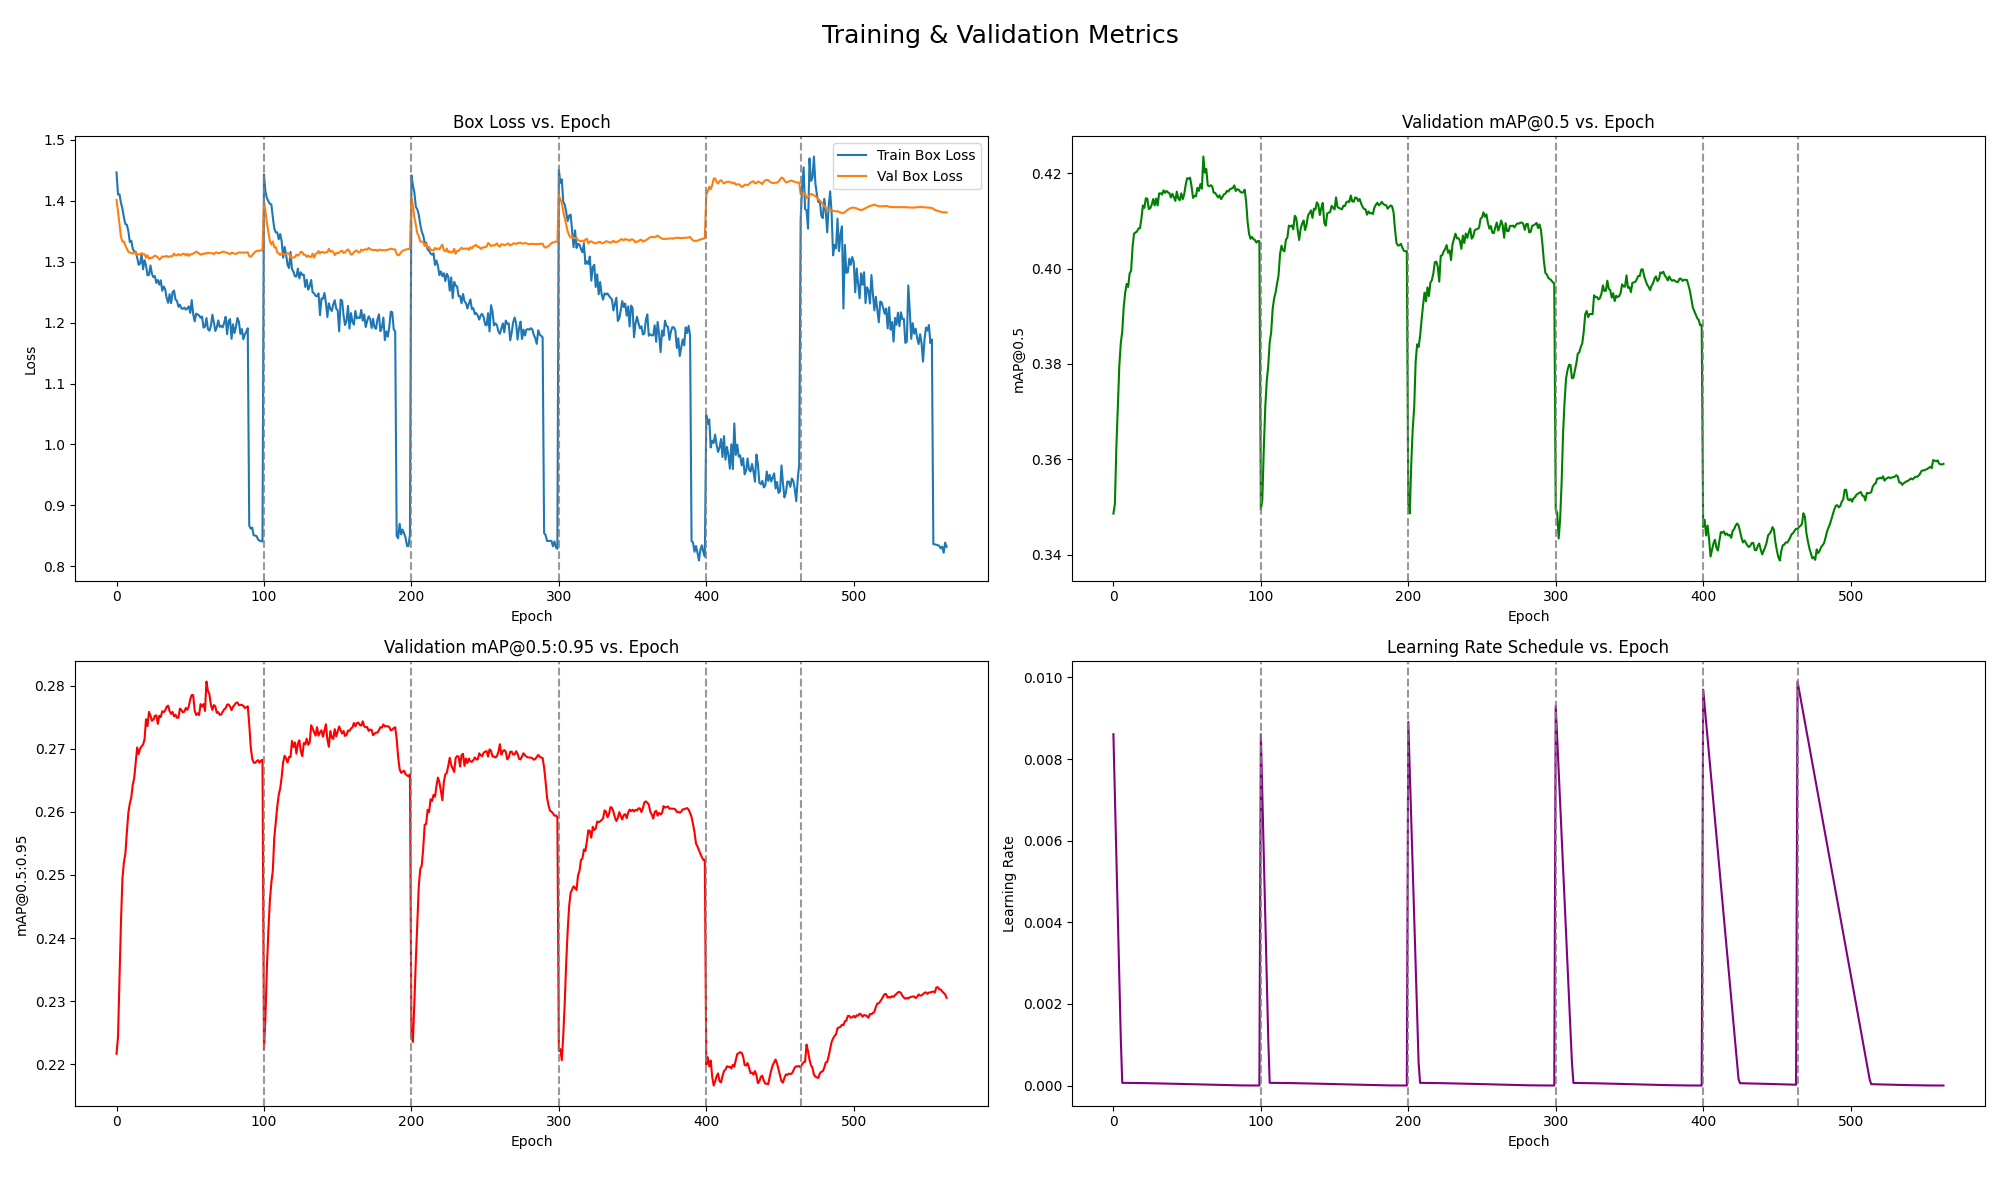

2025-09-27 00:06:55,327 - INFO - Loading final best model from Stage 2: /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/runs/task_10shot_stage2_finetune_model_phase_6/weights/best.pt
2025-09-27 00:06:55,358 - INFO - Evaluator initialized for 80 base and 5 novel classes.
2025-09-27 00:06:55,358 - INFO - 🚀 Starting final model evaluation on the test set...


Ultralytics 8.3.201 🚀 Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA H100 80GB HBM3, 81110MiB)
YOLO11n summary (fused): 100 layers, 2,623,633 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 581.9±181.8 MB/s, size: 143.9 KB)
val: Scanning /N/slate/vivchand/TASK_2/Final/Two_Final_10_1/outputs/combined_dataset/task2/test/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.9Mit/s 0.0s0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10342, len(boxes) = 10371. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/N/u/vivchand/Quartz/.conda/envs/modi/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 0.6it/s 8.3s2.2ss
                   all       1125      10371      0.542      0.349      0.462      0.323
                person        582       2451      0.723      0.661      0.738      0.508
               bicycle         35         80      0.622       0.35      0.511      0.279
                   car        114        431      0.576      0.473      0.548      0.354
            motorcycle         32        101      0.733      0.327      0.541       0.36
              airplane         19         30      0.708      0.567      0.709      0.503
                   bus         34         47      0.789      0.638      0.774      0.672
                 train         24         32      0.593        0.5      0.558      0.373
                 truck         63        103      0.475      0.282      0.378      0.265
                  boat         21         74      0.326      0.203   

2025-09-27 00:07:07,289 - INFO - Parsing per-class metrics to calculate base vs. novel performance.
2025-09-27 00:07:07,292 - INFO - 
📊 Final Performance Summary (Decimal)
   Metric Base Classes Novel Classes Overall
   mAP@50       0.4740        0.2665  0.4617
mAP@50-95       0.3290        0.2243  0.3228
2025-09-27 00:07:07,293 - INFO - 
📊 Final Performance Summary (Percentage)
   Metric Base Classes Novel Classes Overall
   mAP@50       47.40%        26.65%  46.17%
mAP@50-95       32.90%        22.43%  32.28%
2025-09-27 00:07:07,294 - INFO - ✅ Final evaluation complete.
2025-09-27 00:07:07,294 - INFO - 🖼️ Visualizing inference results on Base vs. Novel test images...
2025-09-27 00:07:07,299 - INFO - Displaying 4 samples for 'Base Image'...



0: 640x640 27 cars, 7 traffic lights, 20.7ms
1: 640x640 1 fork, 1 knife, 1 sandwich, 1 dining table, 20.7ms
2: 640x640 1 handbag, 1 suitcase, 20.7ms
3: 640x640 1 cup, 1 spoon, 1 microwave, 1 oven, 1 sink, 20.7ms
Speed: 1.2ms preprocess, 20.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


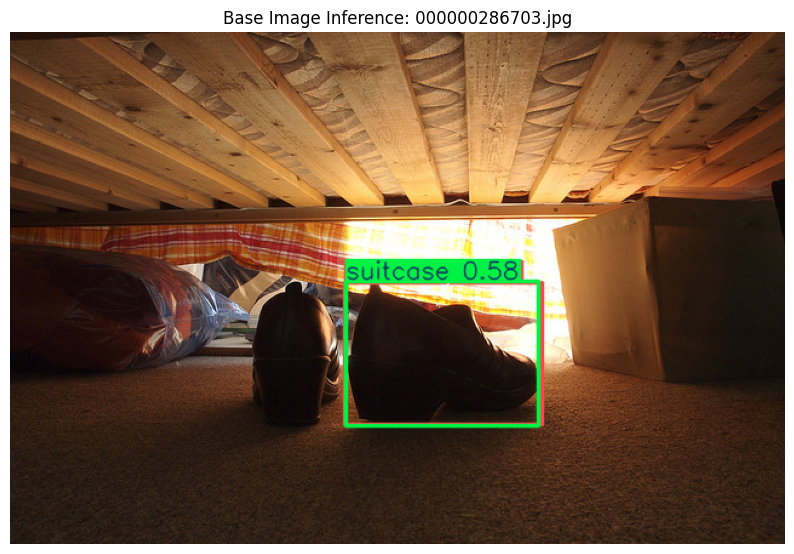

2025-09-27 00:07:08,866 - INFO - Displaying 4 samples for 'Novel Image'...



0: 640x640 1 lamp, 2 photo frames, 1 wardrobe, 1 window, 1.2ms
1: 640x640 1 photo frame, 1.2ms
2: 640x640 2 potted plants, 1 vase, 2 lamps, 1 photo frame, 1.2ms
3: 640x640 1 bed, 1 tv, 1 door, 1 lamp, 1.2ms
Speed: 1.6ms preprocess, 1.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


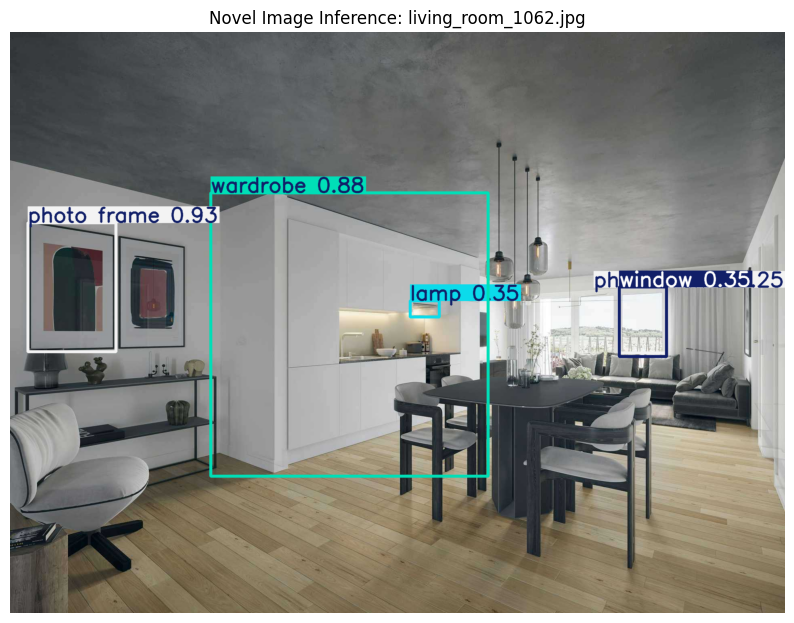

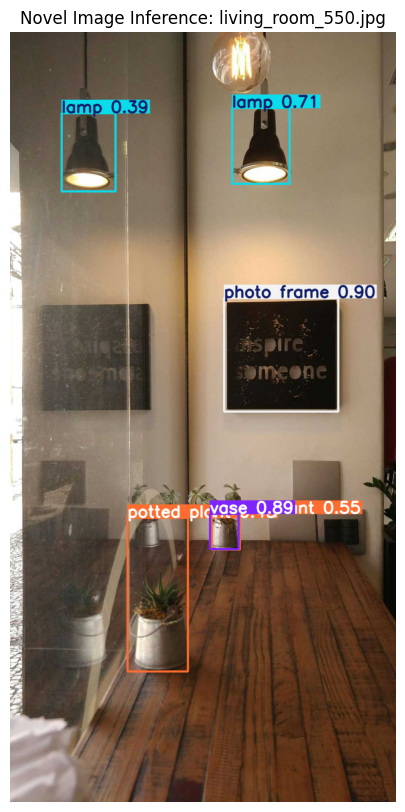

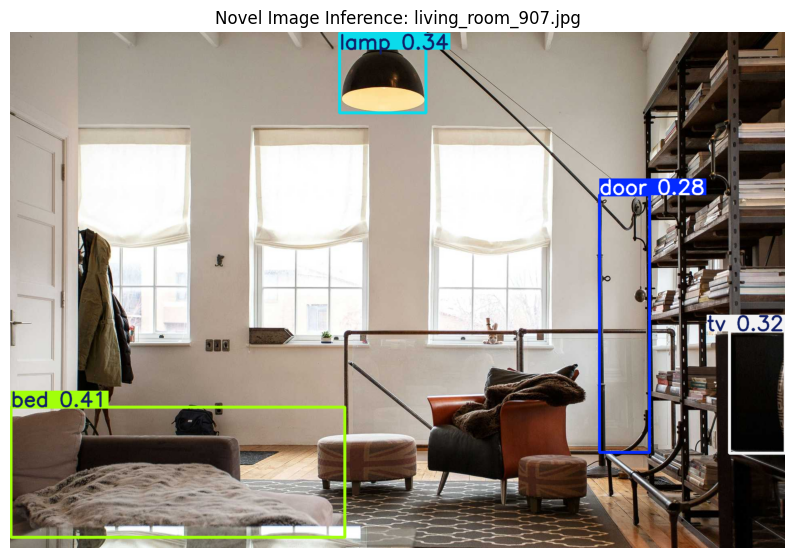

In [9]:

%matplotlib inline

logger.info("="*80)
logger.info("▶️ ANALYZING FINAL STAGE 2 RESULTS")
logger.info("="*80)

# --- Display Final Training Summary Plot ---
output_dir_s2 = Path(config_s2['output_dir'])
plot_path_s2 = output_dir_s2 / f"training_summary_plots_{config_s2['task_name']}.png"
if plot_path_s2.exists():
    logger.info(f"Displaying final training summary plot for Stage 2 from: {plot_path_s2}")
    display(IPyImage(filename=str(plot_path_s2)))
else:
    logger.warning(f"Could not find Stage 2 summary plot at {plot_path_s2}")

# --- Evaluate the Final Model ---
final_model_path = trainer_s2.overall_best_model_path
if final_model_path and final_model_path.exists():
    logger.info(f"Loading final best model from Stage 2: {final_model_path}")
    final_model_s2 = YOLO(str(final_model_path))
    
    evaluator_s2 = Evaluator(config_s2, data_manager)
    evaluator_s2.evaluate_model(final_model_s2)
    
    # --- Visualize Inference from Final Model ---
    logger.info("🖼️ Visualizing inference results on Base vs. Novel test images...")
    all_test_paths = list((data_manager.combined_data_root / "test" / "images").glob("*.*"))
    base_test_filenames = {p.name for p in (data_manager.coco_yaml_path.parent/"images"/"test").glob("*.*")}
    base_only_images = [str(p) for p in all_test_paths if p.name in base_test_filenames]
    novel_only_images = [str(p) for p in all_test_paths if p.name not in base_test_filenames]
    
    # Define the visualization function locally for completeness
    def visualize_inference_subset(model, image_paths, title_prefix, num_samples=4):
        if not image_paths:
            logger.warning(f"No images for subset: {title_prefix}"); return
        
        k = min(num_samples, len(image_paths))
        logger.info(f"Displaying {k} samples for '{title_prefix}'...")
        
        results = model.predict(source=random.sample(image_paths, k=k), conf=0.25)
        for r in results:
            im = Image.fromarray(r.plot()[..., ::-1])
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(im)
            ax.set_title(f"{title_prefix} Inference: {Path(r.path).name}"); ax.axis('off')
            plt.show()

    visualize_inference_subset(final_model_s2, base_only_images, "Base Image")
    visualize_inference_subset(final_model_s2, novel_only_images, "Novel Image")
else:
    logger.error("Could not find the best model from Stage 2.")